In [21]:
from pathlib import Path

import numpy as np
from numba import njit

import matplotlib.pyplot as plt

In [22]:
img_size = 784
img_shape = (28, 28)

train_data_path = Path(r'D:/Development/Python/Jupyter/data/csv/mnist_train_small.csv')
test_data_path = Path(r'D:/Development/Python/Jupyter/data/csv/mnist_test.csv')

data_train = np.loadtxt(train_data_path, delimiter=',')
labels_train = data_train[:,0]
features_train = data_train[:,1:]

data_test = np.loadtxt(test_data_path, delimiter=',')
labels_test = data_test[:,0]
features_test = data_test[:,1:]

In [23]:
x_train = -1+2*(features_train / 255.0)
x_test = -1+2*(features_test / 255.0)

In [24]:
@njit(fastmath=True)
def calc_forces(x: np.ndarray, p: np.ndarray) -> None:
    nn = p.shape[0]
    nx = x.shape[0]
    
    forces: np.ndarray = np.zeros(p.shape)
    
    for i in range(nn):
        dir_x = x - p[i]
        dx = np.sum(np.square(dir_x), axis=1).reshape((nx, 1))
        attr_forces = 1 / (dx + 1) * dir_x
        
        dir_pi = p[i] - p
        dp = np.sum(np.square(dir_pi), axis=1).reshape((nn, 1))
        separation_forces = 1 / (dp + 1) * dir_pi
        
        mean_attr_force = 1 / nx * np.sum(attr_forces, axis=0)
        mean_sep_force = 1 / nn * np.sum(separation_forces, axis=0)

        forces[i] = mean_attr_force + mean_sep_force
        
    return forces

In [25]:
class SelfOrganizingMap:
    def __init__(self, n: int) -> None:
        self.n: int = n

        self.p: np.ndarray = None
        self.d: np.ndarray = None

    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-1, 1, (self.n, data.shape[1]))
    
    def recalc_dist_mtrx(self):
        self.d = np.zeros((self.n, self.n))

        for i, pi in enumerate(self.p):
            for j, pj in enumerate(self.p):
                self.d[i][j] = np.sum(np.square(pi - pj))
    
    def train(self, x_train: np.ndarray, lr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        self._init_weights(x_train)

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                forces = calc_forces(x_train[batch_idxs], self.p)

                self.p += lr * forces

In [33]:
n = 30

learning_rate = 1.0
batch_size = 128
max_epoch = 32

model = SelfOrganizingMap(n)
model.train(x_train, learning_rate, batch_size, max_epoch)

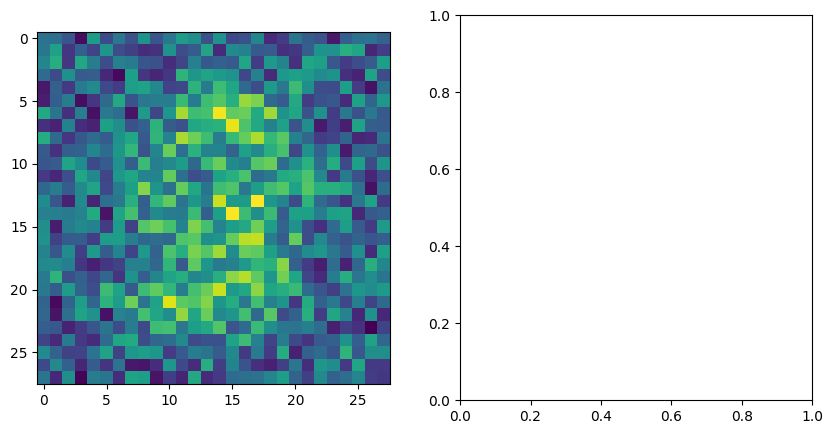

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_dpi(100)
fig.set_figwidth(10)
fig.set_figheight(5)

axes[0].imshow(model.p[0].reshape(img_shape))

plt.show()